# **Aplicaciones Financieras de ML & AI**
## **Examen II:** *Objetos Financieros Parte I*

#### Nombre: Julio César Avila Torreblanca

- **Problema 1:**:
    1. Descargue datos del precio del dólar en pesos mexicanos, use Yahoo Finance.
    2. Proponer una red de arquitectura LSTM que realice una predicción (forecast)
de la serie de tiempo anterior. ¿Es posible mejorar los resultados de un modelo ARIMA?
    3. ¿Es posible utilizar redes neuronales recurrentes en lugar de un modelo
ARCH?, Intente implementarlo y observe los resultados.


- **Contenido del notebook**:
    1. Librerías y parámetros
    2. Lectura de los datos
    3. Forecasting con ARIMA
    4. Forecasting con GARCH
    5. Forecasting con LSTM
    6. Conclusiones



# 1. Librerías y parámetros

In [1]:
#!pip install arch

In [2]:
# data
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import yfinance as yf

# plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# modeling
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from arch import arch_model

import tensorflow as tf
from tensorflow import keras

# test
from sklearn.metrics import mean_squared_error, mean_absolute_error


# 2. Lectura de los datos

In [3]:
data = yf.download(
        tickers = "MXN=X", # dollar price
        period = "1y", # one year information
        interval = "1d", # daily information
    ).loc[:, 'Close']

data = data.rename(columns={'MXN=X': 'dollar_price'})
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Ticker,dollar_price
Date,
2024-04-04,16.527000
2024-04-05,16.573200
2024-04-08,16.452000
2024-04-09,16.314301
2024-04-10,16.383310
...,...
2025-04-01,20.474030
2025-04-02,20.328341
2025-04-03,20.258301


# 3. Forecasting con ARIMA
Los pasos a seguir son:
- Validar si la serie de tiempo es estacionaria, caso contrario, transformar los datos.
- Obtener los valores de p,q
- Entrenar las combinaciones $ARIMA(p,d,q)$
- Seleccionar el mejor modelo
- Análisis de resultados

## 3.1 *Estacionalidad*

In [4]:
# uso de test Dickey-Fuller para ver si la st es estacionaria
ADF_result = adfuller(data['dollar_price'])

print('ADF test con los datos originales:')
print(f'-> ADF Statistic: {ADF_result[0]}')
print(f'-> p-value: {ADF_result[1]}')

ADF test con los datos originales:
-> ADF Statistic: -1.8149703263850325
-> p-value: 0.3730550781771602


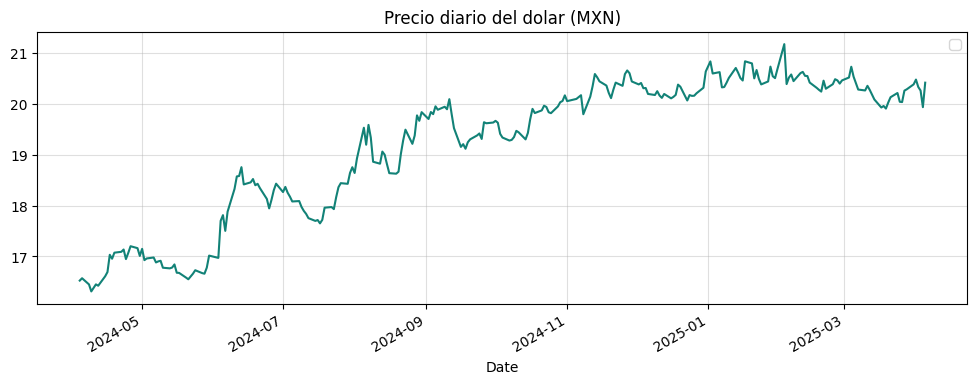

In [5]:
data['dollar_price'].plot(
    figsize = (12,4),
    color='#128277'
)

plt.title("Precio diario del dolar (MXN)")
plt.grid(alpha=0.4)
plt.legend('')
plt.show()

Dado que p-value > 0.05 no se rechaza la hipótesis nula, por ende la serie de tiempo no es estacionaria.

Probaremos con los retornos logaritmicos.

In [6]:
data['log_returns'] = np.log(data['dollar_price']) - np.log(data['dollar_price'].shift(1))
data = data.dropna()

ADF_result = adfuller(data['log_returns'])

print('ADF test con los retornos logarítmicos:')
print(f'-> ADF Statistic: {ADF_result[0]}')
print(f'-> p-value: {ADF_result[1]}')

ADF test con los retornos logarítmicos:
-> ADF Statistic: -12.668103579937222
-> p-value: 1.261812238413855e-23


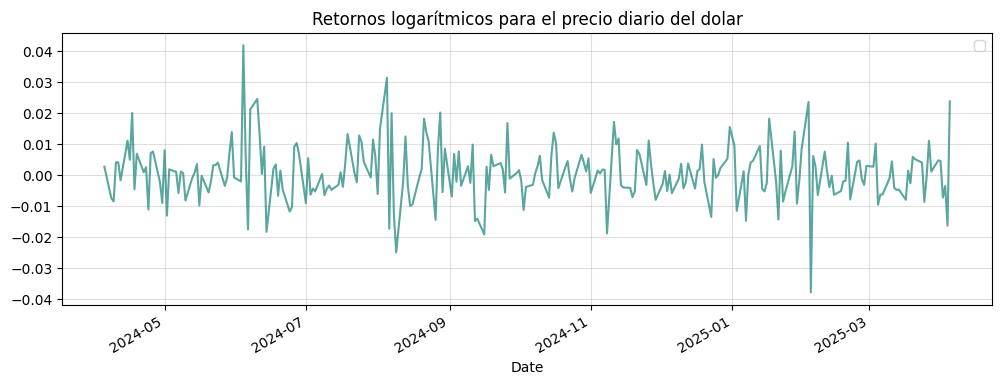

In [7]:
data['log_returns'].plot(
    figsize = (12,4),
    color='#128277',
    alpha=0.7
)

plt.title("Retornos logarítmicos para el precio diario del dolar")
plt.grid(alpha=0.4)
plt.legend('')
plt.show()

Aquí p-value < 0.05, por lo que tomando los retornos logarítmicos del dolar obtenemos una serie de tiempo estacionaria. Trabajaremos con esta.

## 3.2 Obtener $p$, $q$

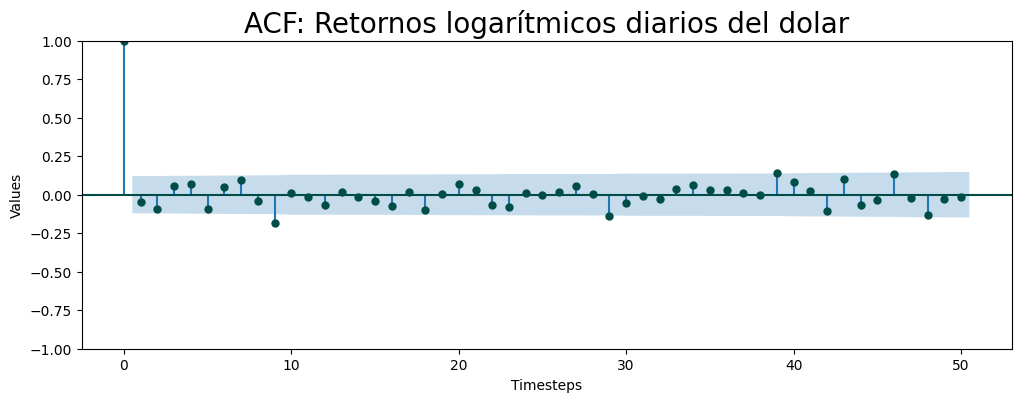

In [8]:
# ACF plot
n_coef = 50
fig, ax = plt.subplots(figsize=(12,4))

plot_acf(
    x=data['log_returns'],
    ax=ax,
    lags=n_coef,
    color='#004D47',
    #alpha=0.7
)
ax.set(
    xlabel='Timesteps',
    ylabel='Values',
    title = 'ACF: Retornos logarítmicos diarios del dolar')
ax.title.set_size(20)
plt.show()

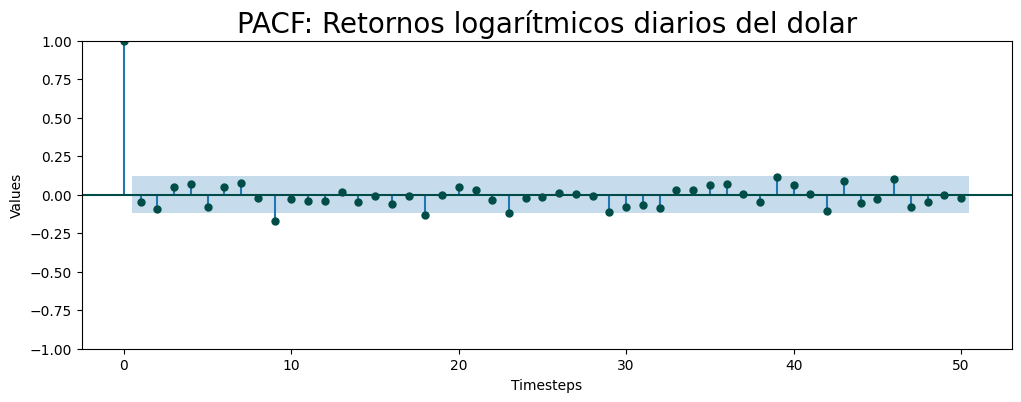

In [9]:
# PACF plot
n_coef = 50
fig, ax = plt.subplots(figsize=(12,4))

plot_pacf(
    x=data['log_returns'],
    ax=ax,
    lags=n_coef,
    color='#004D47',
    #alpha=0.7
)
ax.set(
    xlabel='Timesteps',
    ylabel='Values',
    title = 'PACF: Retornos logarítmicos diarios del dolar')
ax.title.set_size(20)
plt.show()

Analizando los gráficos de ACP y PACF, vemos que solo la serie de tiempo solo tiene autocorrleación con el primer lag, con el resto de valores pasados no se aprecia alguna correlación. Dada la falta de Autocorrelaciones, podemos suponer que el uso del modelo ARIMA puede que no nos llegue a realizar una buena predicción. Por ahora continuaremos con el ejercicio tomando $p,q=1$.

## 3.3 Modelo ARIMA

### 3.3.1 Split data
Tomaremos el último **mes** como test y entrenaremos con el resto de datos.

In [10]:
train_data = data.iloc[:-20,:].copy()
test_data = data.iloc[-20:,:].copy()

print(train_data.shape)
print(test_data.shape)

(241, 2)
(20, 2)


### 3.3.2 Train

In [11]:
# MODELO ARIMA
model_arma = ARIMA(
    train_data['log_returns'],
    order=(1, 0, 1),
    enforce_stationarity=False,
)

model_arma_fitted = model_arma.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [12]:
print(model_arma_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:            log_returns   No. Observations:                  241
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 780.722
Date:                Sun, 06 Apr 2025   AIC                          -1553.444
Time:                        03:16:49   BIC                          -1539.538
Sample:                             0   HQIC                         -1547.840
                                - 241                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.385      0.166      -0.000       0.002
ar.L1         -0.3249      0.860     -0.378      0.706      -2.010       1.360
ma.L1          0.2885      0.871      0.331      0.7

### 3.3.3 Test

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


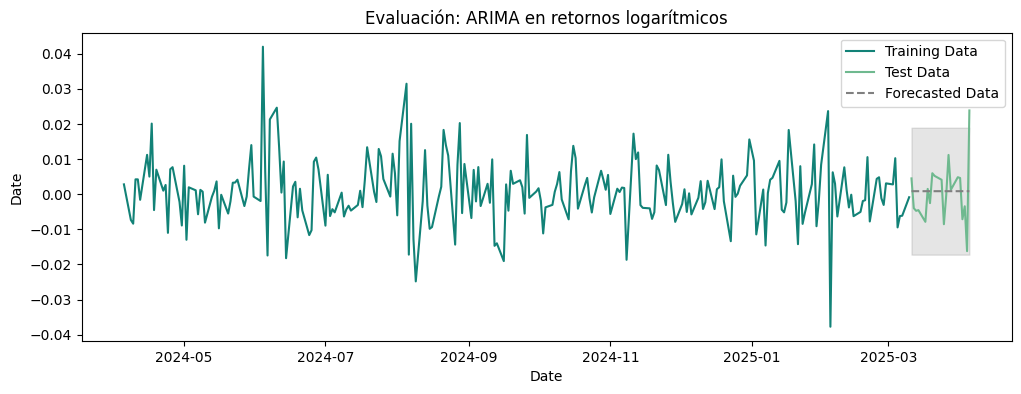

RMSE: 0.0083
MAE: 0.0063


In [13]:
# log returns
test_forecast = model_arma_fitted.get_forecast(steps=len(test_data))
test_forecast_series = pd.Series(test_forecast.predicted_mean.values, index=test_data.index)

# metrics
mse = mean_squared_error(test_data['log_returns'], test_forecast_series)
rmse = mse**0.5
mae = mean_absolute_error(test_data['log_returns'], test_forecast_series)

# plot for comparing
plt.figure(figsize=(12,4))
plt.plot(train_data['log_returns'], label='Training Data', color='#128277')
plt.plot(test_data['log_returns'], label='Test Data', color='#6FB98F',)
plt.plot(test_forecast_series, label='Forecasted Data', color='grey', linestyle='--')
plt.fill_between(test_data.index,
                 test_forecast.conf_int().iloc[:, 0],
                 test_forecast.conf_int().iloc[:, 1],
                 color='k', alpha=.1)
plt.title('Evaluación: ARIMA en retornos logarítmicos')
plt.xlabel('Date')
plt.ylabel('Date')
plt.legend()
plt.show()

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


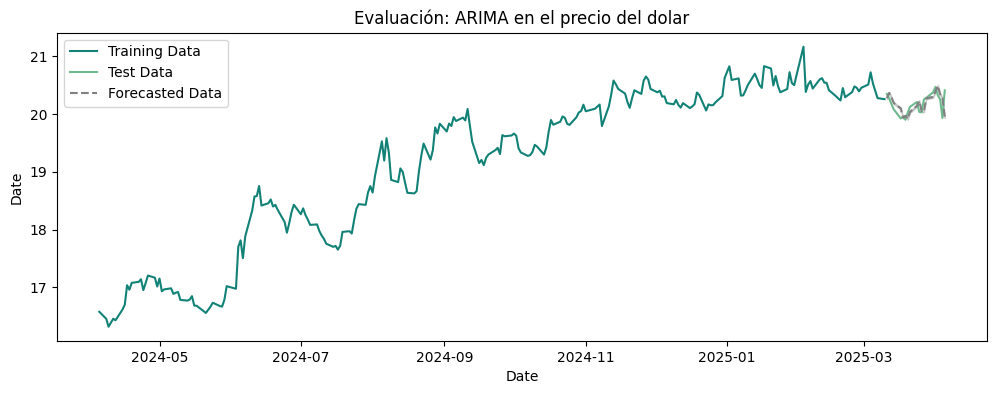

RMSE: 0.1668
MAE: 0.1274


In [14]:
# log returns
test_forecast = model_arma_fitted.get_forecast(steps=len(test_data))
test_forecast_values = test_forecast.predicted_mean.values

# inverse log return
for index,val in enumerate(test_forecast_values):
  test_forecast_values[index] = np.exp(val)*data['dollar_price'].iloc[-21+index]

test_forecast_series = pd.Series(test_forecast_values, index=test_data.index)
# metrics
mse = mean_squared_error(test_data['dollar_price'], test_forecast_series)
rmse = mse**0.5
mae = mean_absolute_error(test_data['dollar_price'], test_forecast_series)

# plot for comparing
plt.figure(figsize=(12,4))
plt.plot(train_data['dollar_price'], label='Training Data', color='#128277')
plt.plot(test_data['dollar_price'], label='Test Data', color='#6FB98F',)
plt.plot(test_forecast_series, label='Forecasted Data', color='grey', linestyle='--')
plt.fill_between(test_data.index,
                 test_forecast.conf_int().iloc[:, 0],
                 test_forecast.conf_int().iloc[:, 1],
                 color='k', alpha=.15)
plt.title('Evaluación: ARIMA en el precio del dolar')
plt.xlabel('Date')
plt.ylabel('Date')
plt.legend()
plt.show()

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


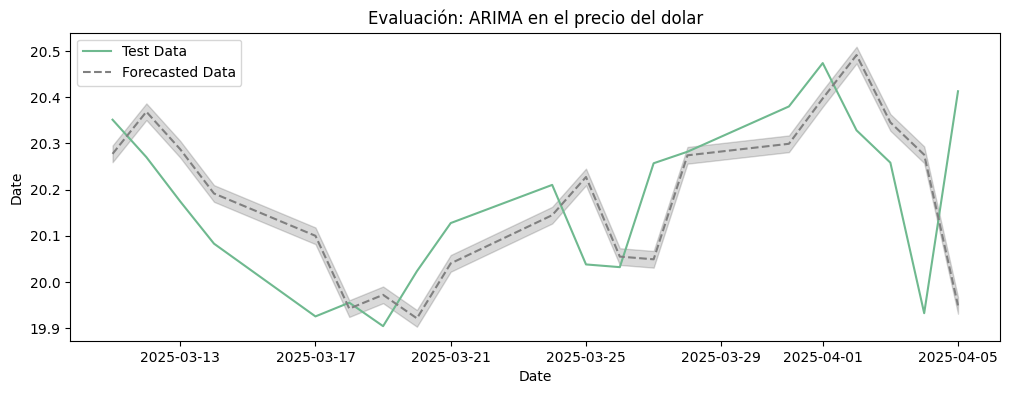

RMSE: 0.1668
MAE: 0.1274


In [15]:
# log returns
test_forecast = model_arma_fitted.get_forecast(steps=len(test_data))
test_forecast_values = test_forecast.predicted_mean.values

# inverse log return
for index,val in enumerate(test_forecast_values):
  test_forecast_values[index] = np.exp(val)*data['dollar_price'].iloc[-21+index]

test_forecast_series = pd.Series(test_forecast_values, index=test_data.index)
# metrics
mse = mean_squared_error(test_data['dollar_price'], test_forecast_series)
rmse = mse**0.5
mae = mean_absolute_error(test_data['dollar_price'], test_forecast_series)

# plot for comparing
plt.figure(figsize=(12,4))
plt.plot(test_data['dollar_price'], label='Test Data', color='#6FB98F',)
plt.plot(test_forecast_series, label='Forecasted Data', color='grey', linestyle='--')
plt.fill_between(test_data.index,
                 test_forecast.conf_int().iloc[:, 0],
                 test_forecast.conf_int().iloc[:, 1],
                 color='k', alpha=.15)
plt.title('Evaluación: ARIMA en el precio del dolar')
plt.xlabel('Date')
plt.ylabel('Date')
plt.legend()
plt.show()

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

### 3.3.4. Conclusión

El modelo ARIMA a pesar de tener métricas de RMSE y MAE bajas, podemos notar en el último gráfico que la predicción obtenida es tan solo el valor anterior. Por ende el modelo no logra capturar completamente el comportamiento de la serie de tiempo. Probemos con otros métodos.

# 4. Forecasting con GARCH

Dado que ya hemos procesado y analizado los datos, iremos directamente al proceso de modelado con GARCH.*texto en cursiva*

## 4.1 Train

In [138]:
fechas_vol = data.index
for cada_fecha in fechas_vol[125:]:
    data_for_vol = fechas_vol[(cada_fecha - fechas_vol < pd.Timedelta(days=180)) & (cada_fecha - fechas_vol >= pd.Timedelta(days=0))] # 120 dias para 6 meses
    data.loc[cada_fecha, 'Volatility'] = np.std(data['log_returns'][data_for_vol].values, ddof=1)*np.sqrt(252)

In [139]:
model_garch = arch_model(data['Volatility'].dropna().values[:-20]*10, mean='Zero', vol='ARCH', p=15)
model_garch_fitted = model_garch.fit()

Iteration:      1,   Func. Count:     18,   Neg. LLF: 514.4840900281454
Iteration:      2,   Func. Count:     38,   Neg. LLF: 405.2015808791162
Iteration:      3,   Func. Count:     55,   Neg. LLF: 405.4164682502254
Iteration:      4,   Func. Count:     73,   Neg. LLF: 404.51787943070093
Iteration:      5,   Func. Count:     91,   Neg. LLF: 403.62565643558435
Iteration:      6,   Func. Count:    108,   Neg. LLF: 403.57927091526255
Iteration:      7,   Func. Count:    125,   Neg. LLF: 403.5777479914236
Iteration:      8,   Func. Count:    142,   Neg. LLF: 403.5777449836922
Iteration:      9,   Func. Count:    158,   Neg. LLF: 403.57774501884796
Optimization terminated successfully    (Exit mode 0)
            Current function value: 403.5777449836922
            Iterations: 9
            Function evaluations: 158
            Gradient evaluations: 9


In [140]:
model_garch_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - ARCH Model Results                        
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.005
Vol Model:                       ARCH   Log-Likelihood:               -403.578
Distribution:                  Normal   AIC:                           839.155
Method:            Maximum Likelihood   BIC:                           893.526
                                        No. Observations:                  221
Date:                Sun, Apr 06 2025   Df Residuals:                      221
Time:                        04:54:21   Df Model:                            0
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1908      0.132      1.448      0.148 [-6.748e-02,  0.449]
alpha[1]       0.9161      0.170      5.403  6.546e-08    [  0.584,  1.248]
alpha[2]   4.2692e-15      0.177  2.407e-14      1.000    [ -0.348,  0.348]
alpha[3]   5.4096e-15      0.202  2.673e-14      1.000    [ -0.397,  0.397]
alpha[4]   2.2424e-15      0.197  1.139e-14      1.000    [ -0.386,  0.386]
alpha[5]   1.0998e-15      0.214  5.149e-15      1.000    [ -0.419,  0.419]
alpha[6]       0.0000      0.167      0.000      1.000    [ -0.327,  0.327]
alpha[7]   2.0679e-16      0.231  8.966e-16      1.000    [ -0.452,  0.452]
alpha[8]       0.0000      0.238      0.000      1.000    [ -0.466,  0.466]
alpha[9]   7.9068e-16      0.122  6.501e-15      1.000    [ -0.238,  0.238]
alpha[10]      0.0000      0.108      0.000      1.000    [ -0.211,  0.211]
alpha[11]  6.7936e-16      0.121  5.609e-15      1.000    [ -0.237,  0.237]
alpha[12]      0.0000      0.196      0.000      1.000    [ -0.384,  0.384]
alpha[13]      0.0000      0.234      0.000      1.000    [ -0.459,  0.459]
alpha[14]      0.0000  9.282e-02      0.000      1.000    [ -0.182,  0.182]
alpha[15]      0.0000  8.177e-02      0.000      1.000    [ -0.160,  0.160]
===========================================================================

Covariance estimator: robust
"""

In [141]:
forecasts = model_garch_fitted.forecast(horizon=20)
forecast_volatility = pd.Series(forecasts.variance[-1:].values.flatten(), index=test_data.index)

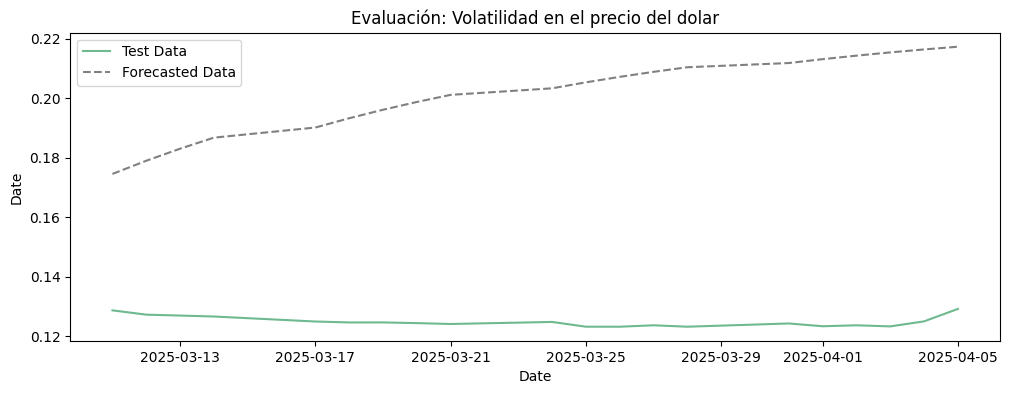

RMSE: 0.1668
MAE: 0.1274


In [142]:
# plot for comparing
plt.figure(figsize=(12,4))
#plt.plot(test_data['log_returns'], label='Test Data', color='#6FB98F',)
plt.plot(data.iloc[-20:,:]['Volatility'], label='Test Data', color='#6FB98F',)
plt.plot(forecast_volatility/10, label='Forecasted Data', color='grey', linestyle='--')

plt.title('Evaluación: Volatilidad en el precio del dolar')
plt.xlabel('Date')
plt.ylabel('Date')
plt.legend()
plt.show()

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

In [143]:
data['Volatility'][-20:]

,Volatility
Date,
2025-03-11,0.128722
2025-03-12,0.127277
2025-03-13,0.126971
2025-03-14,0.126653
2025-03-17,0.124974
2025-03-18,0.124662
2025-03-19,0.124668
2025-03-20,0.124435
2025-03-21,0.124138


In [144]:
forecast_volatility/10

,0
Date,
2025-03-11,0.174562
2025-03-12,0.178986
2025-03-13,0.183039
2025-03-14,0.186751
2025-03-17,0.190152
2025-03-18,0.193268
2025-03-19,0.196122
2025-03-20,0.198736
2025-03-21,0.201131
